In [1]:
import sys
from pathlib import Path
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

project_root = str(Path.cwd().parent.parent.parent)

if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary modules
from src.models.custom_functions import (
    SafeIdentityFunction, SafeLog, SafeExp,
    SafeSin, SafePower, SafeCos
)
from src.training.trainer import Trainer
from src.training.connectivity_trainer import ConnectivityTrainer
from src.utils.plotting import plot_results
from src.utils.data_utils import get_data_loaders, generate_astro_data
from src.models.model_initialization import initialize_model

from src.utils.astro_utils import *


In [2]:
def fn_train(train_loader, val_loader):
    # Define the set of functions
    function_set = {
            "identity": SafeIdentityFunction(),
            "exp": SafeExp(),
            "log": SafeLog(),
            "sin": SafeSin(),
            "cos": SafeCos(),
            "power": SafePower(),
            # Idea: Add "x" function just to know x in the layer
        }

    # Training configuration
    config = {
        'training': {
            'num_epochs': 1000,
            'learning_rate': 0.01,
            'reg_strength': 0.0001,
            'decimal_penalty': 0.01,
            'scheduler': 'progressive',  # One of: cosine, cyclic, progressive
            # Connectivity training specific parameters
            'use_connectivity_training': False,  # Set to False for classical training
            'max_architectures': 10,
            'max_patterns_per_layer': 5,
            'num_parallel_trials': 1,
            'print_training_stats': True
        }
    }

    # Model configuration
    input_size = 1
    output_size = 1
    num_layers = 2
    nonlinear_info = [(2, 0), (0, 0), (0, 0)]


    model = initialize_model(
        input_size,
        output_size, 
        num_layers,
        function_set, 
        nonlinear_info, 
        min_connections_per_neuron=1, 
        exp_n=1002)

    # Train the model using original trainer
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        config=config,
        device=device
    )
    trainer.train()
    trained_model = model
    return trained_model

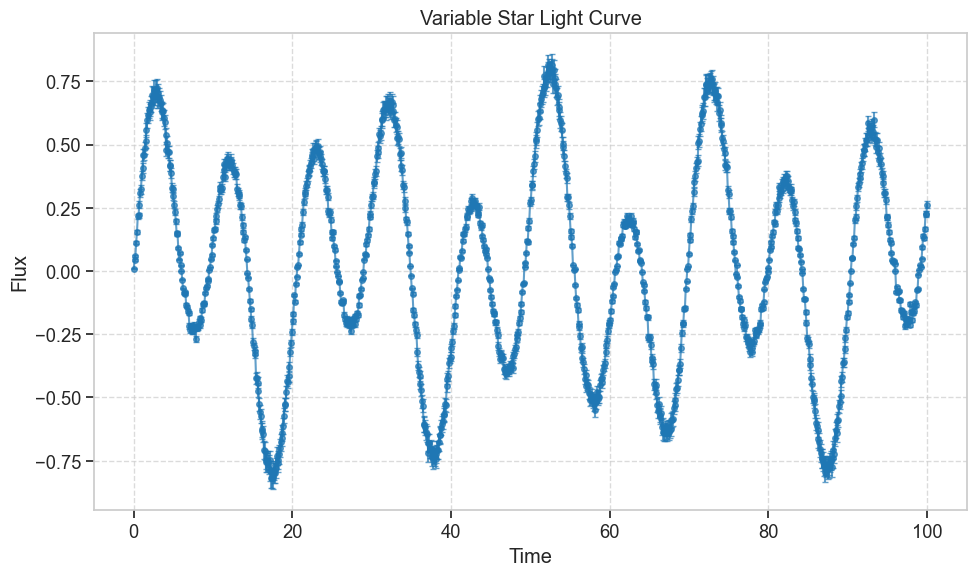

In [6]:
vs_light_curve = create_sample_light_curve(n_points=1000, curve_type='variable_star')
# Visualize each type
visualize_light_curve(vs_light_curve, "Variable Star Light Curve")
plt.tight_layout()
plt.show()

In [7]:
# Convert to numpy arrays and then to PyTorch tensors
X = torch.tensor(vs_light_curve['time'].values.reshape(-1, 1), dtype=torch.float32)
y = torch.tensor(vs_light_curve['flux'].values.reshape(-1, 1), dtype=torch.float32)

# Now you can use get_data_loaders
train_loader, val_loader = get_data_loaders(X, y, batch_size=64)

In [5]:
# To verify the shapes and types:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X type:", type(X))
print("y type:", type(y))

X shape: torch.Size([200, 1])
y shape: torch.Size([200, 1])
X type: <class 'torch.Tensor'>
y type: <class 'torch.Tensor'>


In [10]:
trained_model = fn_train(train_loader, val_loader)

Epoch 1/1000 - Train Loss: 90.851561 - Val Loss: 72.534102
Epoch 2/1000 - Train Loss: 47.923612 - Val Loss: 34.749079
Epoch 3/1000 - Train Loss: 34.480557 - Val Loss: 27.507778
Epoch 4/1000 - Train Loss: 27.137725 - Val Loss: 25.312392
Epoch 5/1000 - Train Loss: 24.169680 - Val Loss: 20.172128
Epoch 6/1000 - Train Loss: 20.883172 - Val Loss: 17.884545
Epoch 7/1000 - Train Loss: 18.496523 - Val Loss: 16.071869
Epoch 8/1000 - Train Loss: 16.631991 - Val Loss: 14.277456
Epoch 9/1000 - Train Loss: 15.054917 - Val Loss: 13.092859
Epoch 10/1000 - Train Loss: 13.833778 - Val Loss: 11.817040
Epoch 11/1000 - Train Loss: 12.826941 - Val Loss: 11.085089
Epoch 12/1000 - Train Loss: 12.064559 - Val Loss: 10.600948
Epoch 13/1000 - Train Loss: 11.523836 - Val Loss: 10.167273
Epoch 14/1000 - Train Loss: 11.092497 - Val Loss: 9.799116
Epoch 15/1000 - Train Loss: 10.775797 - Val Loss: 9.570936
Epoch 16/1000 - Train Loss: 10.553719 - Val Loss: 9.433980
Epoch 17/1000 - Train Loss: 10.394597 - Val Loss: 9.

Final equation: y1 = -0.00771*sin(0.99647*x1) + 0.02427*sin(1.12611*x1)


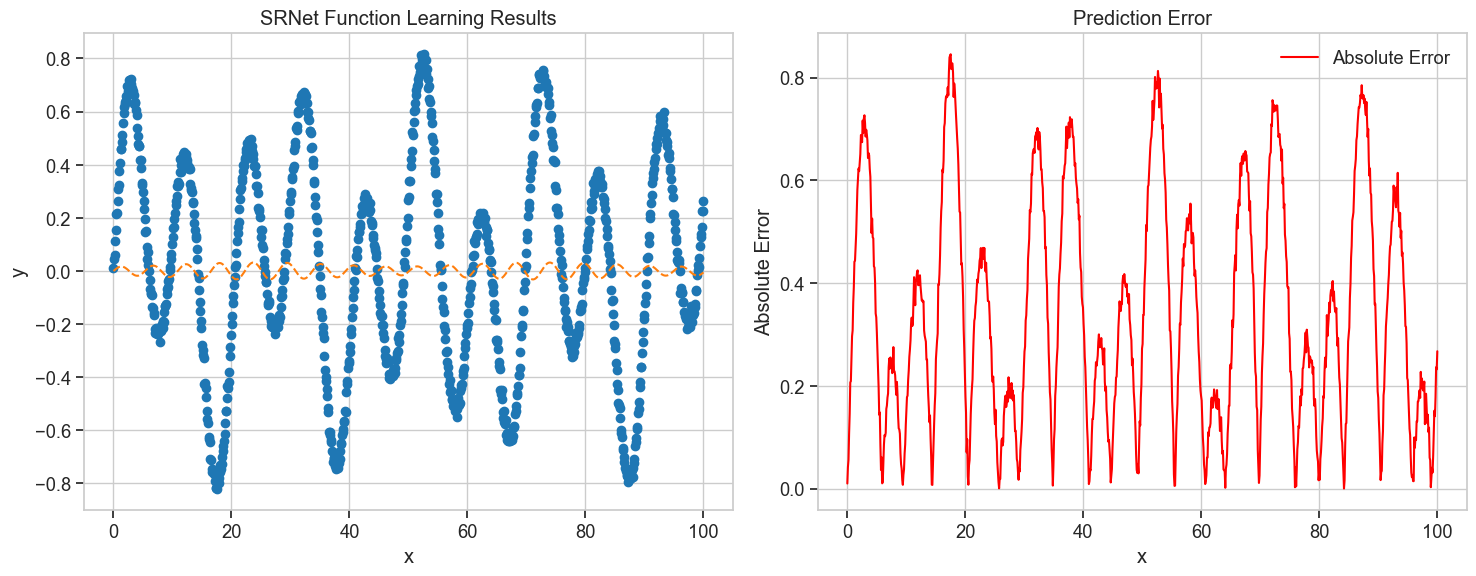

In [11]:
# Get the final equation and evaluate results
device = 'cuda' if torch.cuda.is_available() else 'cpu'


equation = trained_model.get_equation()
print(f"Final equation: {equation}")

# Evaluate model
trained_model.eval()
with torch.no_grad():
    predictions = trained_model(X.to(device))
    predictions = predictions.cpu()

plot_results(X, y, predictions)

In [22]:
!pip install astropy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.5 MB/s eta 0:00:00


In [24]:
# Convert PyTorch tensors to NumPy arrays
time = X.numpy().flatten()  # Convert to NumPy and flatten to 1D
flux = y.numpy().flatten()  # Convert to NumPy and flatten to 1D

In [25]:
from astropy.timeseries import LombScargle
# Define frequency range
min_period = 5  # Minimum expected period
max_period = 23   # Maximum expected period

# Convert period range to frequency range
min_freq = 1 / max_period
max_freq = 1 / min_period
frequencies = np.linspace(min_freq, max_freq, 1000)  # 1000 frequency points

# Initialize LombScargle periodogram
ls = LombScargle(time, flux)

# Compute power
power = ls.power(frequencies)


In [26]:
best_frequency = frequencies[np.argmax(power)]
best_period = 1 / best_frequency  # Convert frequency to period
print(f"Best period found: {best_period:.2f} units of time")


Best period found: 10.00 units of time


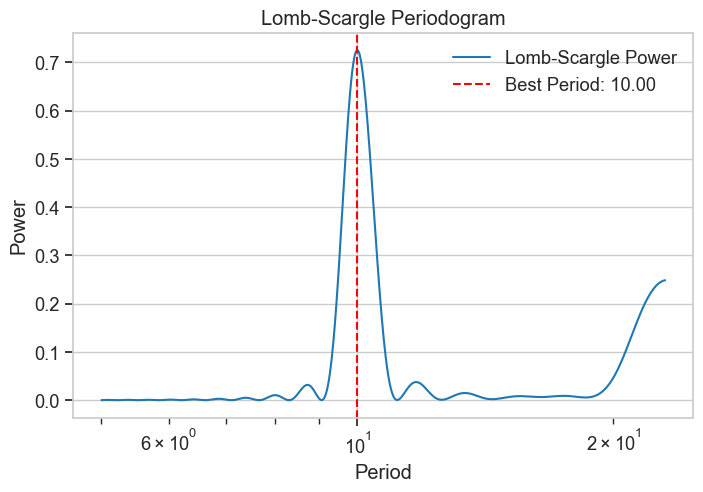

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(1 / frequencies, power, label="Lomb-Scargle Power")
plt.axvline(best_period, color='r', linestyle='--', label=f"Best Period: {best_period:.2f}")
plt.xlabel("Period")
plt.ylabel("Power")
plt.xscale("log")  # Log scale helps when periods vary widely
plt.legend()
plt.title("Lomb-Scargle Periodogram")
plt.show()


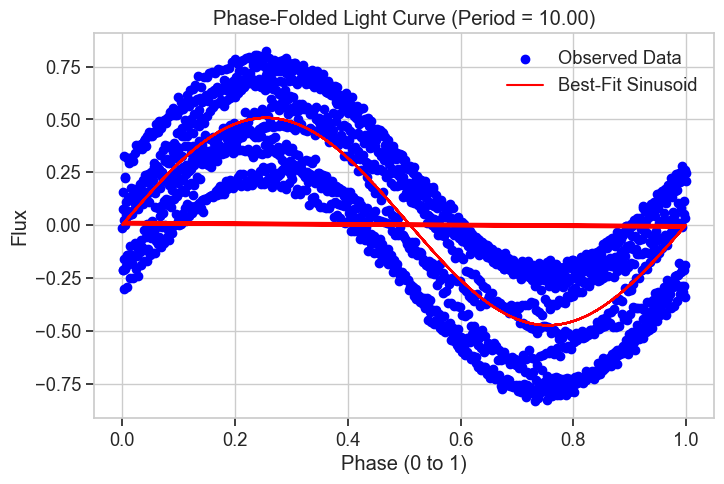

In [28]:
# Generate model data
phase = (time % best_period) / best_period  # Normalize to phase [0, 1]
model_flux = ls.model(time, best_frequency)

plt.figure(figsize=(8, 5))
plt.scatter(phase, flux, label="Observed Data", color="blue")
plt.plot(phase, model_flux, label="Best-Fit Sinusoid", color="red")
plt.xlabel("Phase (0 to 1)")
plt.ylabel("Flux")
plt.legend()
plt.title(f"Phase-Folded Light Curve (Period = {best_period:.2f})")
plt.show()


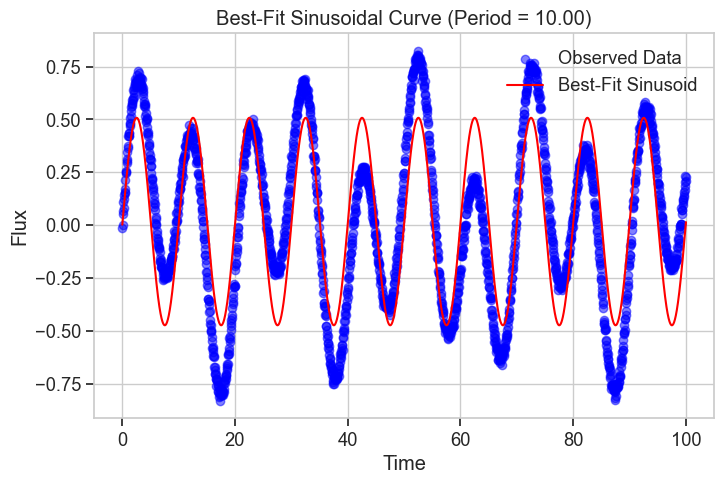

In [29]:
# Generate high-resolution time points for a smooth fitted curve
time_fine = np.linspace(time.min(), time.max(), 5000)  # More points for smoothness
model_flux_fine = ls.model(time_fine, best_frequency)

# Plot the original time vs. observed flux
plt.figure(figsize=(8, 5))
plt.scatter(time, flux, label="Observed Data", color="blue", alpha=0.5)
plt.plot(time_fine, model_flux_fine, label="Best-Fit Sinusoid", color="red")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.title(f"Best-Fit Sinusoidal Curve (Period = {best_period:.2f})")
plt.show()
